<br><br>
<div dir="rtl">



# بيانات NOAA المناخية

سنستخدم واجهة **NOAA API** لجلب بيانات محطات الطقس في المملكة العربية السعودية، ثم عرضها على خريطة تفاعلية باستخدام مكتبة **Folium** في بايثون.


## ما هي NOAA؟

هي الإدارة الوطنية للمحيطات والغلاف الجوي في الولايات المتحدة، وتوفر قواعد بيانات مفتوحة تشمل محطات الطقس، وبيانات مناخية، وأرصاد جوية حول العالم.

 **ملاحظة**:  
لا تشمل جميع المحطات الجوية في المملكة العربية السعودية، بل تقتصر على ٣٢ محطة.

## الاهداف

- عرض محطات الطقس على خريطة تفاعلية  
- عرض الرسوم البيانية لدرجات الحرارة   
- تحميل بيانات متوسط درجات الحرارة اليومية بصيغة CSV  

<br><br>
</div>


<div dir="rtl" style="text-align: right;">

 **لاستخدام واجهة NOAA لجلب البيانات المناخية، تحتاج إلى مفتاح API مجاني.
اتبع الخطوات التالية:**

<div dir="rtl" style="text-align: right;">

##  1  
افتح موقع NOAA للحصول على مفتاح API.


 https://www.ncdc.noaa.gov/cdo-web/token
<br><br>
##  2  
سجل بالايميل للحصول على المفتاح.
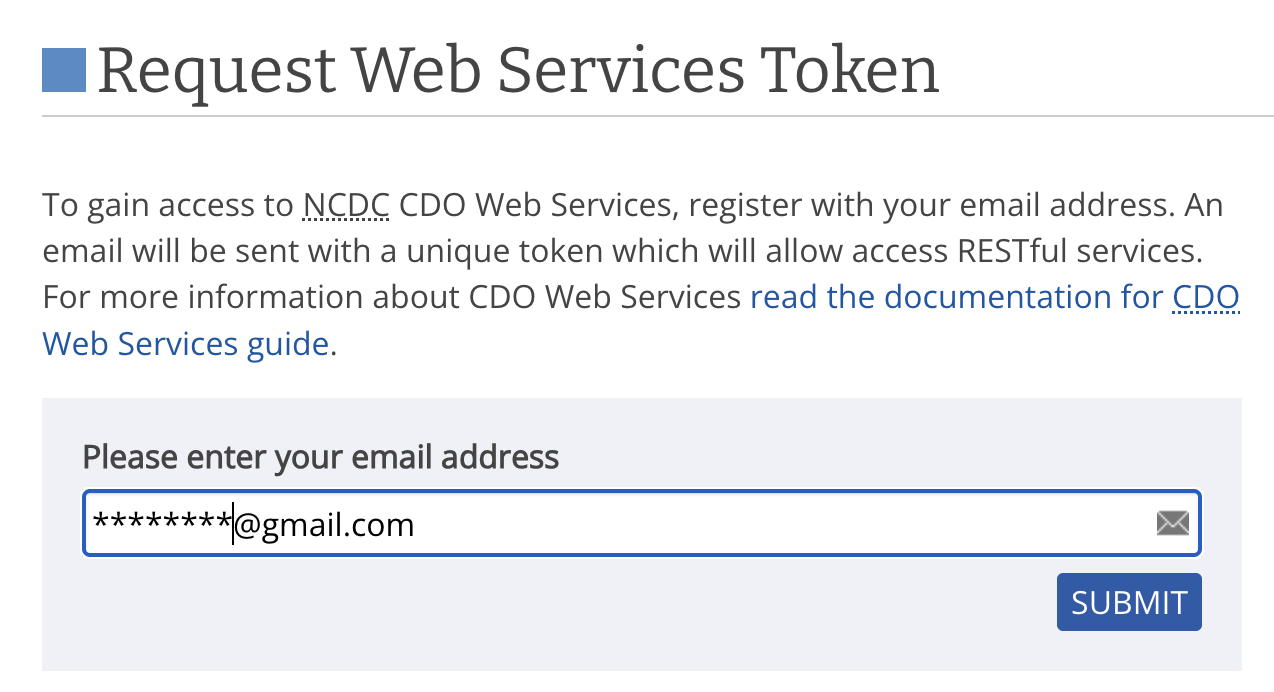
<br><br>




</div>


<br><br>
<div dir="rtl">

##  3  
سيتم ارسال المفتاح إلي البريد الإلكتروني
قم بنسخه من Token.

<br><br>
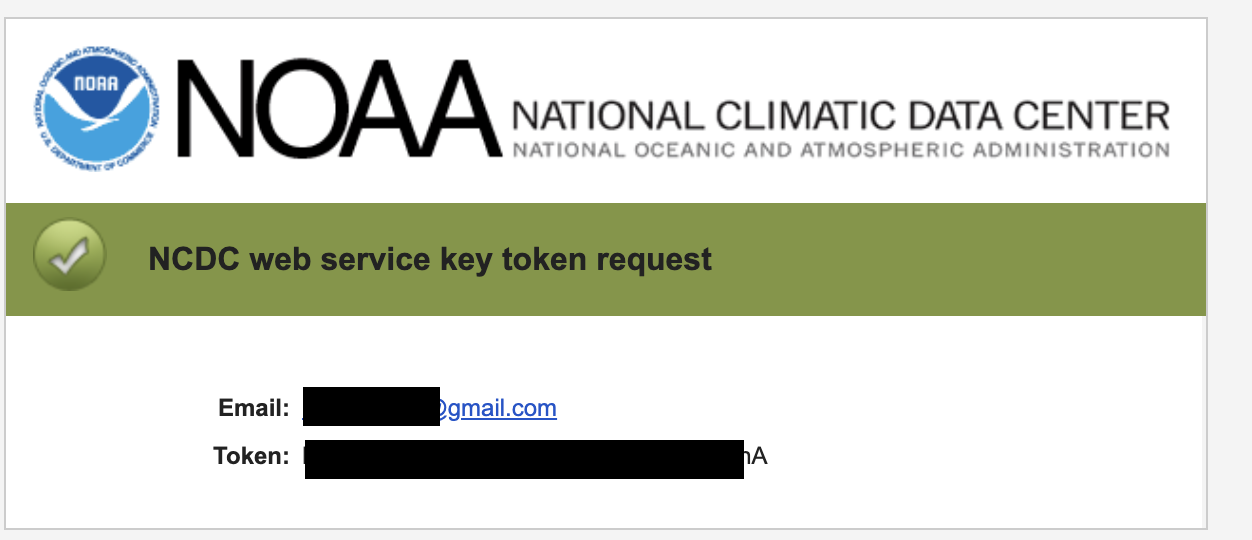
<div dir="rtl">


In [2]:
# ───────────────────────────────────────────────────────────────
#  تحميل المكتبات
# ───────────────────────────────────────────────────────────────


!pip install arabic-reshaper python-bidi ipywidgets > /dev/null 2>&1

import requests
import pandas as pd
import folium
from getpass import getpass
import matplotlib.pyplot as plt
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display
import ipywidgets as widgets
from matplotlib.ticker import MaxNLocator
import time
from google.colab import files
from IPython.display import display, clear_output
import base64
import io
from tqdm.notebook import tqdm


print("✅ تم تثبيت الحزم المطلوبة بنجاح")


✅ تم تثبيت الحزم المطلوبة بنجاح


In [3]:

## Token قم بنسخ المفتاح من الايميل بعد كلمة

API_KEY = getpass("مفتاح NOAA API : ")


 أدخل مفتاح NOAA API : ··········


In [4]:
# ───────────────────────────────────────────────────────────────
# هنا نقوم بطلب المحطات وموقعها من السيرفر الخاص بالموقع
# ───────────────────────────────────────────────────────────────


def get_saudi_stations(retries=3, wait=5):
    url = "https://www.ncei.noaa.gov/cdo-web/api/v2/stations"
    headers = {"Token": API_KEY}
    params = {
        "locationid": "FIPS:SA",
        "datasetid": "GHCND",
        "limit": 1000
    }

    for attempt in range(1, retries + 1):
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 200:
            return response.json().get("results", [])
        else:
            print(f"⚠️ المحاولة {attempt}: تعذر الوصول إلى محطات الطقس (خطأ {response.status_code})")
            if attempt < retries:
                time.sleep(wait)
            else:
                raise Exception(f"❌ فشل الاتصال بعد {retries} محاولات.\n{response.text}")

stations = get_saudi_stations()
df = pd.DataFrame(stations)


columns_to_show = ["id", "name", "latitude", "longitude", "elevation", "mindate", "maxdate"]
df = df[columns_to_show]


In [15]:
# ───────────────────────────────────────────────────────────────
# هنا تظهر المحطات وتاريخ بداية الرصد و انتهائه لكل محطة
# ───────────────────────────────────────────────────────────────


m = folium.Map(location=[24.0, 45.0], zoom_start=5, tiles='CartoDB positron',
               width=800, height=600)
#folium.TileLayer('CartoDB positron').add_to(m)


for _, row in df.iterrows():
    if pd.notnull(row["latitude"]) and pd.notnull(row["longitude"]):
        popup = (
            f"<b>{row['name']}</b><br>"
            f"ID: {row['id']}<br>"
            f"Elevation: {row['elevation']} m<br>"
            f"Data Range: {row['mindate']} to {row['maxdate']}"
        )
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=popup,
            icon=folium.Icon(color="blue", icon="cloud")
        ).add_to(m)


m

In [6]:
# ───────────────────────────────────────────────────────────────
#  لتحميل كافة اسامي المحطات وموقعها الجغرافي قم بتشغيل هذه الخلية
# ───────────────────────────────────────────────────────────────

df.to_csv("noaa_saudi_stations.csv", index=False)
from google.colab import files
files.download("noaa_saudi_stations.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# ───────────────────────────────────────────────────────────────
# هنا سنقوم باظهار النتائج على شكل رسوم بيانيه مه امكانية تحديد المحطة و المدى الزمني ٢/١
# ───────────────────────────────────────────────────────────────

def get_station_yearly_data(station_id, start_year=2000, end_year=2024, delay=0.5, debug=True):
    yearly_averages = []

    if debug:
        print(f"\n{'='*50}")
        print(f"Fetching data for station: {station_id}")
        print(f"Time period: {start_year} to {end_year}")
        print(f"{'='*50}")

    for year in range(start_year, end_year + 1):
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"

        if debug:
            print(f"\nProcessing year: {year} ({start_date} to {end_date})")

        url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
        headers = {"token": API_KEY}
        params = {
            "datasetid": "GHCND",
            "stationid": station_id,
            "startdate": start_date,
            "enddate": end_date,
            "units": "metric",
            "limit": 1000,
            "datatypeid": "TAVG"
        }

        all_data = []
        offset = 0
        more_data = True
        page_count = 0

        while more_data:
            page_count += 1
            params["offset"] = offset
            time.sleep(delay)

            success = False
            for attempt in range(1, 4):
                response = requests.get(url, headers=headers, params=params)
                if response.status_code == 200:
                    success = True
                    break
                else:
                    print(f"⚠️ محاولة {attempt}: خطأ {response.status_code} عند جلب بيانات سنة {year}")
                    time.sleep(2 ** attempt)

            if not success:
                break

            data = response.json()
            results = data.get("results", [])

            if not results:
                more_data = False
            else:
                all_data.extend(results)
                offset += len(results)
                if offset >= data.get("metadata", {}).get("resultset", {}).get("count", 0):
                    more_data = False

        if all_data:
            df_year = pd.DataFrame(all_data)
            yearly_avg = df_year["value"].mean()
            yearly_averages.append({"year": year, "value": yearly_avg})
        else:
            yearly_averages.append({"year": year, "value": np.nan})

    return pd.DataFrame(yearly_averages)


def arabic_text(text):
    reshaped = arabic_reshaper.reshape(text)
    return get_display(reshaped)

def create_station_temp_map(fmap, delay=0.05, data_cache=None, max_stations=None):
    stations = get_saudi_stations()
    df_stations = pd.DataFrame(stations)
    df_stations = df_stations[["id", "name", "latitude", "longitude"]]

    if max_stations:
        df_stations = df_stations.head(max_stations)

    start = 2010 # ─────────────────────────────────────────────────────────────── تاريخ البداية
    end = 2020 # ─────────────────────────────────────────────────────────────── تاريخ النهاية

    for _, row in tqdm(df_stations.iterrows(), total=len(df_stations), desc="📍 معالجة المحطات"):
        station_id = row["id"]
        station_name = row["name"]
        lat, lon = row["latitude"], row["longitude"]

        try:
            yearly_data = get_station_yearly_data(
                station_id,
                start_year=start,
                end_year=end,
                delay=delay,
                debug=False
            )
        except:
            continue

        if yearly_data.empty:
            # Optional fallback marker if no data
            folium.Marker(
                location=[lat, lon],
                popup=folium.Popup(f"<b>{station_name}</b><br>ID: {station_id}<br>لا تتوفر بيانات كافية", max_width=250),
                icon=folium.Icon(color="gray")
            ).add_to(fmap)
            continue

        yearly_data = yearly_data.set_index("year").reindex(range(start, end + 1)).reset_index()
        yearly_data.columns = ["year", "value"]

        if yearly_data["value"].dropna().empty:
            folium.Marker(
                location=[lat, lon],
                popup=folium.Popup(f"<b>{station_name}</b><br>ID: {station_id}<br>لا تتوفر بيانات كافية", max_width=250),
                icon=folium.Icon(color="gray")
            ).add_to(fmap)
            continue

        if data_cache is not None:
            data_cache[station_id] = {
                "name": station_name,
                "data": yearly_data
            }

        fig, ax = plt.subplots(figsize=(5, 2.5))
        ax.plot(yearly_data["year"], yearly_data["value"], marker='o', linestyle='-', color='#1f77b4', label=arabic_text("البيانات المتوفرة"))

        missing = yearly_data[yearly_data["value"].isna()]
        if not missing.empty:
            ax.scatter(missing["year"], [yearly_data["value"].mean()] * len(missing), color='red', marker='x', label=arabic_text("بيانات مفقودة"))

        ax.set_title(arabic_text("متوسط الحرارة السنوي"), fontsize=10)
        ax.set_xlabel(arabic_text("السنة"))
        ax.set_ylabel("°C")
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(fontsize=8)
        fig.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches='tight')
        buf.seek(0)
        img_base64 = base64.b64encode(buf.read()).decode("utf-8")
        plt.close(fig)

        html = f"""
        <b>{station_name}</b><br>
        ID: {station_id}<br>
        المدة: {start} - {end}<br>
        <img src="data:image/png;base64,{img_base64}" width="320">
        """

        folium.Marker(
            location=[lat, lon],
            popup=folium.Popup(html, max_width=350),
            tooltip=station_name
        ).add_to(fmap)

    return fmap


fmap = folium.Map(location=[23.8859, 45.0792], zoom_start=5, tiles='CartoDB positron',
                  width=800, height=600)


station_yearly_data = {}
m1 = create_station_temp_map(fmap, data_cache=station_yearly_data)




📍 معالجة المحطات:   0%|          | 0/32 [00:00<?, ?it/s]

⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2019
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2011
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2020
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2015
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2016
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2020
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2011
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2019
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2016
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2019
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2010
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2011
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2013
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2012
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2018
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2019
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2010
⚠️ محاولة 1: خطأ 503 عند جلب بيانات سنة 2015



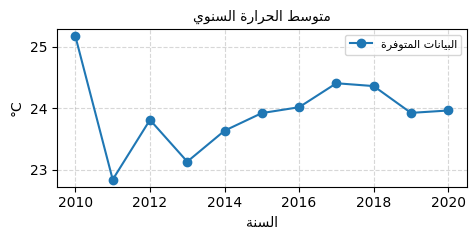
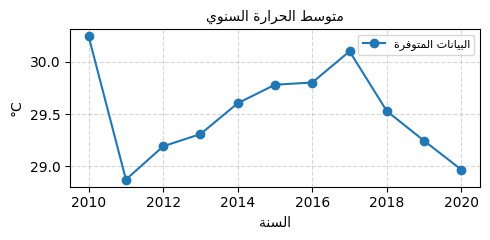
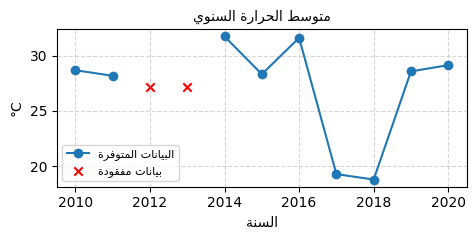
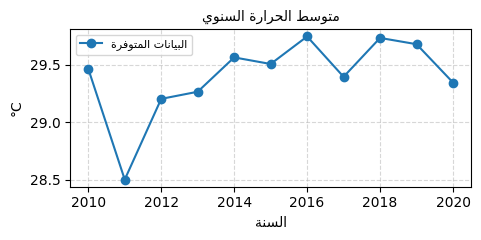
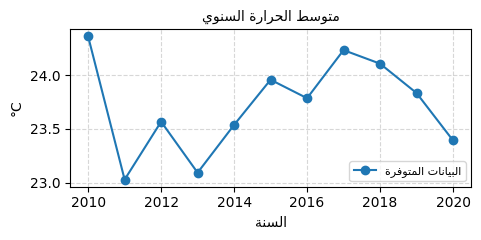
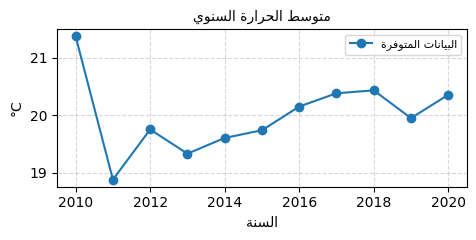
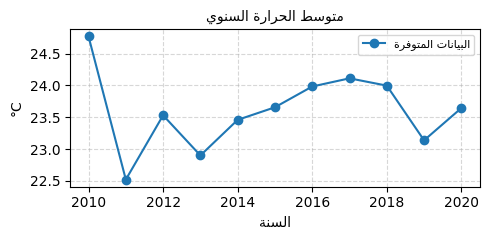
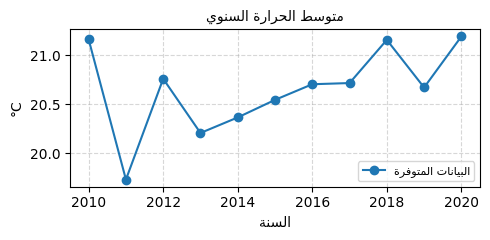
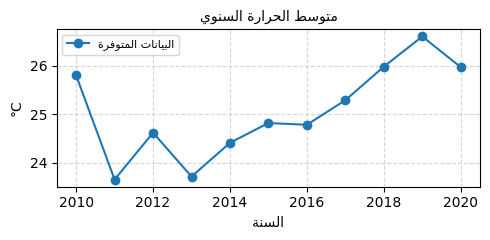
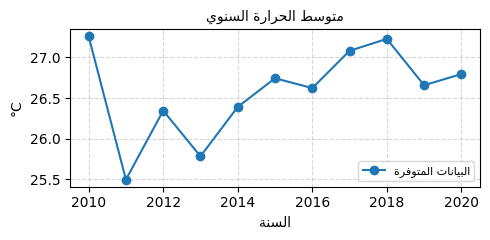
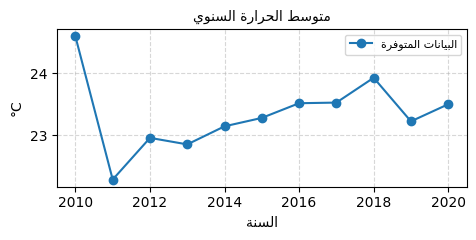
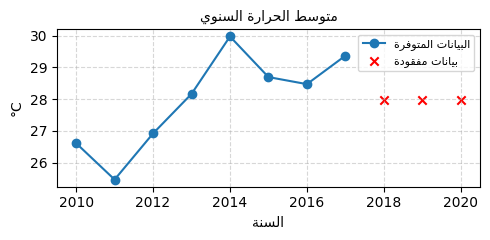
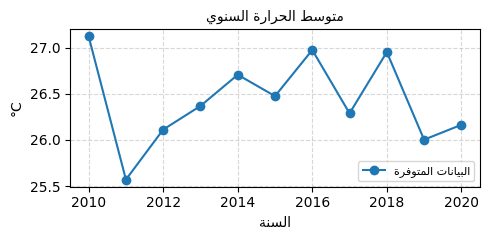
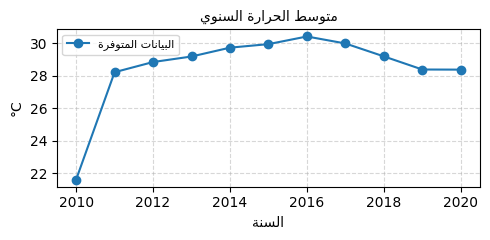
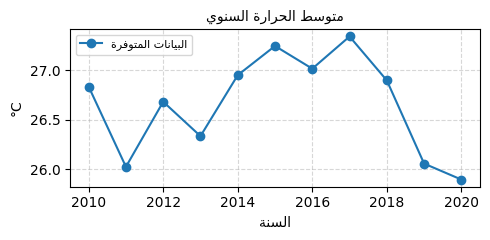
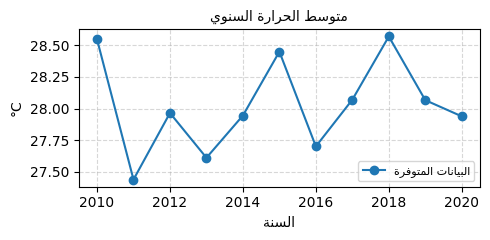
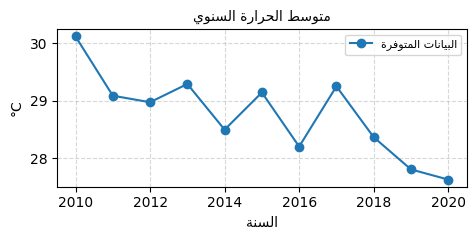
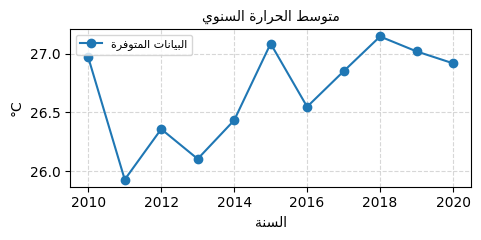
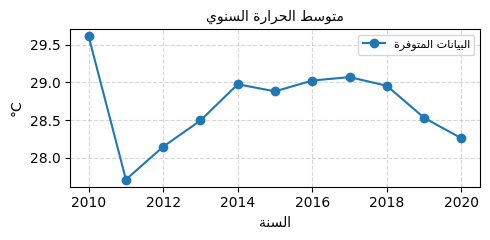
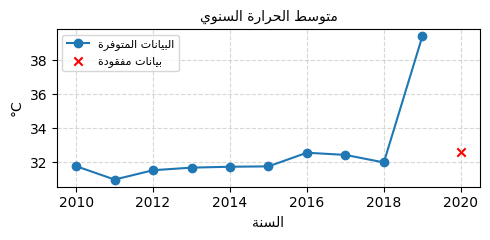
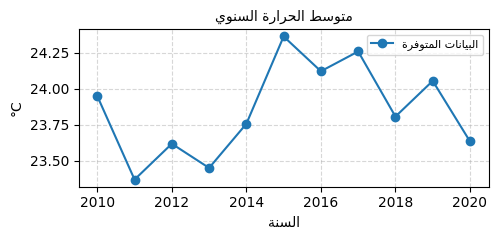
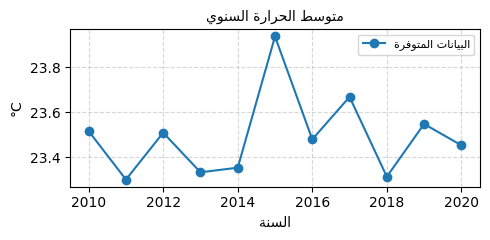
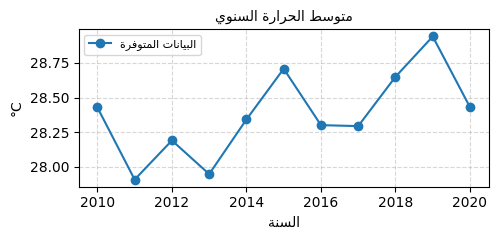
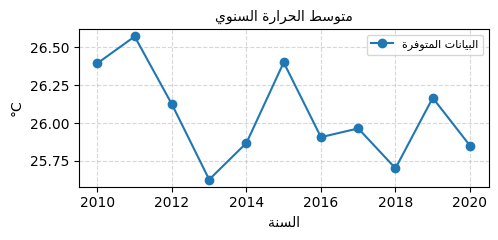
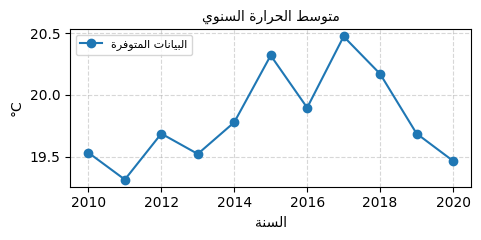
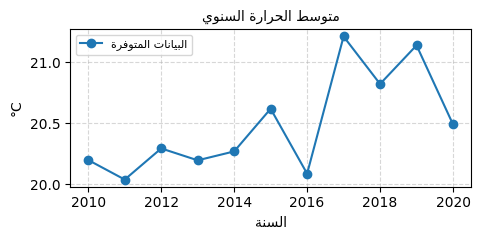
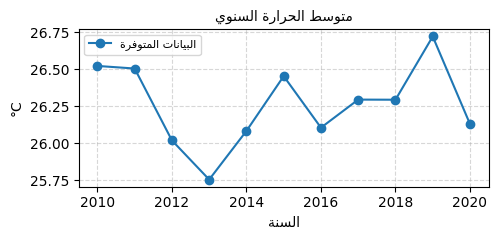
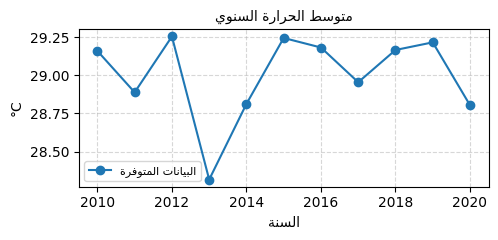
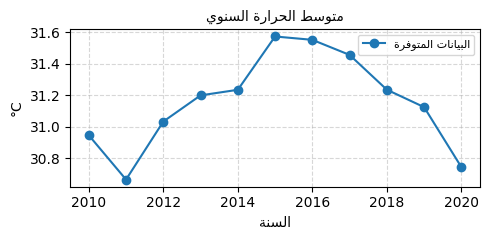
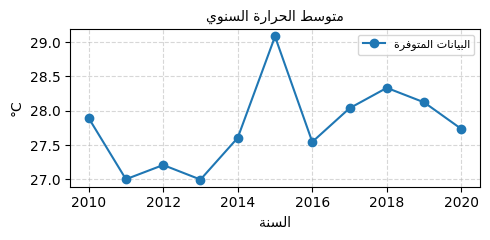

In [16]:
m1

In [17]:
# ───────────────────────────────────────────────────────────────
# هنا سنقوم باظهار النتائج على شكل رسوم بيانيه مه امكانية تحديد المحطة و المدى الزمني ٢/٢
# ───────────────────────────────────────────────────────────────


def arabic_text(text):
    reshaped = arabic_reshaper.reshape(text)
    return get_display(reshaped)


def plot_station_yearly_temp(station_id, station_name, yearly_data):
    plt.figure(figsize=(14, 6))

    years = yearly_data['year'].values
    values = yearly_data['value'].values


    num_years = len(years)
    bar_width = 0.6 if num_years > 25 else 0.8

    bars = plt.bar(
        years,
        values,
        width=bar_width,
        color='#4fa4f7',
        alpha=0.85,
        edgecolor='gray',
        linewidth=0.5
    )


    for i, value in enumerate(values):
        if pd.isna(value):
            plt.text(years[i], 0.5, 'None', ha='center', va='bottom', color='red', fontweight='bold')


    title = f"متوسط درجة الحرارة السنوي لمحطة {station_name} ({station_id})"
    plt.title(arabic_text(title), fontsize=16, fontweight='bold', color='#333')
    plt.xlabel(arabic_text("السنة"), fontsize=13)
    plt.ylabel(arabic_text("متوسط درجة الحرارة (°C)"), fontsize=13)


    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))


    if len(years) > 20:
        plt.xticks(rotation=45)
    elif len(years) > 10:
        plt.xticks(years[::2])


    for bar, value in zip(bars, values):
        if not pd.isna(value) and value > 0:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.4,
                     f'{value:.1f}°C', ha='center', va='bottom', fontsize=10, color='#333')

    plt.tight_layout()
    plt.savefig(f"{station_id}_yearly_temp.png")
    plt.show()

def station_selector_ui():
    stations = get_saudi_stations()
    df_stations = pd.DataFrame(stations)
    df_stations = df_stations[["id", "name", "mindate", "maxdate"]]


    options = [('-- اختر محطة --', None)] + [(row['name'], row['id']) for _, row in df_stations.iterrows()]
    station_dropdown = widgets.Dropdown(
        options=options,
        description='اختر محطة:',
        layout=widgets.Layout(width='60%'),
        style={'description_width': 'initial'}
    )

    start_year_dropdown = widgets.Dropdown(description='من سنة:', layout=widgets.Layout(width='40%'))
    end_year_dropdown = widgets.Dropdown(description='إلى سنة:', layout=widgets.Layout(width='40%'))


    plot_button = widgets.Button(
        description='📊 عرض الرسم البياني',
        button_style='primary',
        icon='bar-chart'
    )

    output = widgets.Output()


    def update_year_range(station_id):
        if station_id is None:
            start_year_dropdown.options = []
            end_year_dropdown.options = []
            return
        row = df_stations[df_stations['id'] == station_id].iloc[0]
        years = list(range(pd.to_datetime(row['mindate']).year, pd.to_datetime(row['maxdate']).year + 1))
        start_year_dropdown.options = years
        end_year_dropdown.options = years
        start_year_dropdown.value = years[0]
        end_year_dropdown.value = years[-1]

    def on_station_change(change):
        update_year_range(change['new'])

    station_dropdown.observe(on_station_change, names='value')

    def on_plot_click(b):
        output.clear_output()
        station_id = station_dropdown.value
        if station_id is None:
            with output:
                print("❗ الرجاء اختيار محطة.")
            return

        start_year = start_year_dropdown.value
        end_year = end_year_dropdown.value

        if start_year > end_year:
            with output:
                print("❌ السنة الابتدائية لا يمكن أن تكون أكبر من السنة النهائية.")
            return

        row = df_stations[df_stations['id'] == station_id].iloc[0]
        station_name = row['name']

        with output:
            print(f"\n⏳ جاري معالجة بيانات المحطة: {station_name} ({station_id}) للفترة {start_year} - {end_year}")
            yearly_data = get_station_yearly_data(
                station_id,
                start_year=start_year,
                end_year=end_year,
                delay=0.5,
                debug=False
            )
            if not yearly_data.empty:
                plot_station_yearly_temp(station_id, station_name, yearly_data)
            else:
                print(f"❌ لا توجد بيانات متاحة لمحطة {station_name}.")

    plot_button.on_click(on_plot_click)

    display(widgets.VBox([
        station_dropdown,
        widgets.HBox([start_year_dropdown, end_year_dropdown]),
        plot_button,
        output
    ]))


    update_year_range(station_dropdown.value)



station_selector_ui()


In [18]:
# ───────────────────────────────────────────────────────────────
# بتشغيل هذه الخليه يمكن تحميل متوسط درجات الحراره اليومية عن طريق اختيار المحطة و السنوات
# ───────────────────────────────────────────────────────────────

def arabic_text(text):
    reshaped = arabic_reshaper.reshape(text)
    return get_display(reshaped)

def get_saudi_stations():
    url = "https://www.ncei.noaa.gov/cdo-web/api/v2/stations"
    headers = {"Token": API_KEY}
    params = {
        "locationid": "FIPS:SA",
        "datasetid": "GHCND",
        "limit": 1000
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        raise Exception(f"Error fetching stations: {response.status_code}\n{response.text}")
    return response.json().get("results", [])

def fetch_year_chunk(station_id, year, delay=1.0):

    url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": API_KEY}
    start = f"{year}-01-01"
    end = f"{year}-12-31"
    all_data = []
    params = {
        "datasetid": "GHCND",
        "stationid": station_id,
        "startdate": start,
        "enddate": end,
        "units": "metric",
        "limit": 1000,
        "datatypeid": "TAVG"
    }

    offset = 0
    while True:
        params["offset"] = offset
        try:
            response = requests.get(url, headers=headers, params=params)
            if response.status_code != 200:
                print(f"⚠️ خطأ {response.status_code} عند جلب بيانات سنة {year}")
                return pd.DataFrame()  # return empty

            results = response.json().get("results", [])
            if not results:
                print(f"📭 لا توجد بيانات متاحة لسنة {year}")
                return pd.DataFrame()  # empty year, API worked

            all_data.extend(results)
            offset += len(results)
            time.sleep(delay)

            if len(results) < 1000:
                break  # no more pages
        except Exception as e:
            print(f"❌ خطأ غير متوقع في سنة {year}: {e}")
            return pd.DataFrame()

    return pd.DataFrame(all_data)

    return pd.DataFrame(all_data)

def full_data_download_ui():
    stations = get_saudi_stations()
    df_stations = pd.DataFrame(stations)
    df_stations = df_stations[["id", "name", "latitude", "longitude", "elevation", "mindate", "maxdate"]]


    station_dropdown = widgets.Dropdown(
        options=[(row["name"], row["id"]) for _, row in df_stations.iterrows()],
        description='اختر محطة:',
        layout=widgets.Layout(width='70%'),
        style={'description_width': 'initial'}
    )


    start_year_dropdown = widgets.Dropdown(description='من سنة:', layout=widgets.Layout(width='40%'))
    end_year_dropdown = widgets.Dropdown(description='إلى سنة:', layout=widgets.Layout(width='40%'))


    download_btn = widgets.Button(
        description='⬇️ تحميل البيانات',
        button_style='success',
        icon='download'
    )

    output = widgets.Output()


    def update_years(change):
        station_id = change["new"]
        row = df_stations[df_stations["id"] == station_id].iloc[0]
        mindate = pd.to_datetime(row["mindate"]).year
        maxdate = pd.to_datetime(row["maxdate"]).year
        years = list(range(mindate, maxdate + 1))
        start_year_dropdown.options = years
        end_year_dropdown.options = years
        start_year_dropdown.value = mindate
        end_year_dropdown.value = maxdate

    station_dropdown.observe(update_years, names="value")


    def on_download_click(b):
        output.clear_output()
        with output:
            station_id = station_dropdown.value
            row = df_stations[df_stations["id"] == station_id].iloc[0]

            name = row["name"]
            lat = row["latitude"]
            lon = row["longitude"]
            elev = row["elevation"]
            start_year = start_year_dropdown.value
            end_year = end_year_dropdown.value

            if start_year > end_year:
                print("❌ تحقق من التواريخ: لا يمكن أن تكون السنة الابتدائية أكبر من النهائية.")
                return

            print(f" جاري تحميل البيانات من {start_year} إلى {end_year} للمحطة {name} ...")
            all_years = []
            for year in range(start_year, end_year + 1):
                print(f"⏳ سنة {year} ...")
                df = fetch_year_chunk(station_id, year, delay=1.0)
                if not df.empty:
                    all_years.append(df)

            if all_years:
                df_final = pd.concat(all_years)
                df_final["station_name"] = name
                df_final["latitude"] = lat
                df_final["longitude"] = lon
                df_final["elevation_m"] = elev

                filename = f"{station_id.replace(':', '_')}_{start_year}_to_{end_year}_daily.csv"
                df_final.to_csv(filename, index=False)
                print(f"✅ تم تحميل {len(df_final)} سجل. جاري التنزيل...")
                files.download(filename)
            else:
                print("❌ لا توجد بيانات متاحة لهذا النطاق الزمني.")

    download_btn.on_click(on_download_click)


    update_years({'new': station_dropdown.value})

    display(widgets.VBox([
        station_dropdown,
        widgets.HBox([start_year_dropdown, end_year_dropdown]),
        download_btn,
        output
    ]))


full_data_download_ui()

<br><br>
<div dir="rtl">



##  المراجع
- [بوابة NOAA لبيانات المناخ](https://www.ncei.noaa.gov/cdo-web/)
<br><br>

- [دليل واجهة NOAA API](https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation)
<br><br>

- [وثائق مكتبة Folium للخرائط التفاعلية](https://python-visualization.github.io/folium/)
<br><br>
- [مكتبة Matplotlib للرسوم البيانية](https://matplotlib.org/stable/gallery/index.html)
